### Set-up

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!cd /content/drive/MyDrive/Mantises!/

Mounted at /content/drive


In [ ]:
!pip install --upgrade pip
!pip install --upgrade netCDF4 xarray
!pip install geopandas matplotlib requests rasterio rioxarray shapely


In [ ]:
# For data manipulation and visualization
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os

# For HTTP requests
import requests
from bs4 import BeautifulSoup

# For working with multi-dimensional arrays and netCDF files
import xarray as xr
import netCDF4 as nc

# For spatial data manipulation
from rasterio.features import Affine, geometry_mask
import rioxarray
from shapely.geometry import mapping
from shapely.ops import transform
import pyproj
from pyproj import CRS, Proj
from functools import partial


###Import your desired shapefiles for clipping

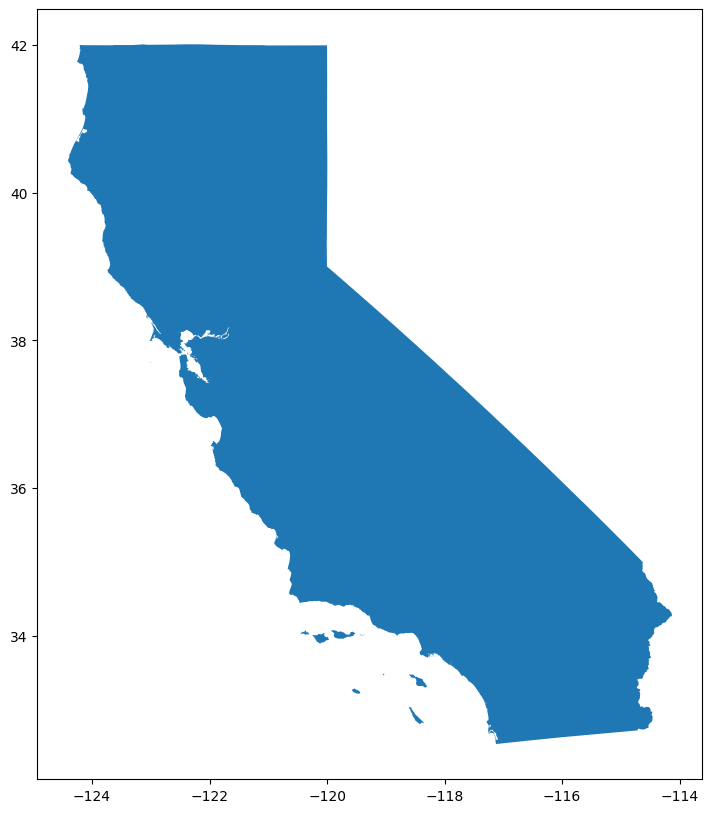

In [ ]:
gdf = gpd.read_file('/content/drive/MyDrive/Mantises!/data/gadm41_USA_shp/gadm41_USA_1.shp')
# Originally downloaded from:
## https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_USA_shp.zip

state = 'California'
bounding_shapefile = gdf[gdf['NAME_1'] == state]
fig, ax = plt.subplots(figsize=(10, 10))
bounding_shapefile.plot(ax=ax)
plt.show()


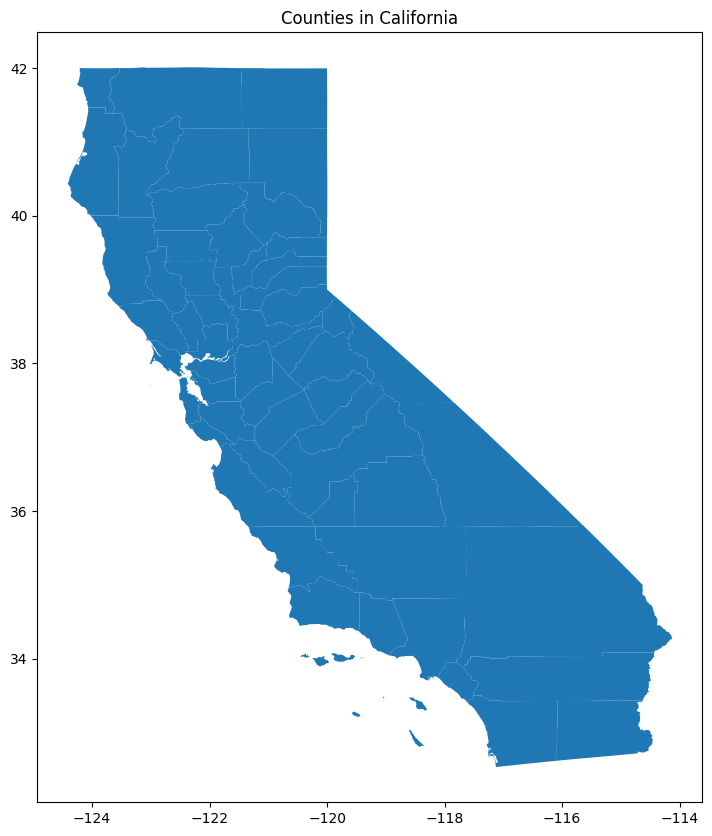

In [ ]:
# Load the county-level shapefile
gdf_counties = gpd.read_file('/content/drive/MyDrive/Mantises!/data/gadm41_USA_shp/gadm41_USA_2.shp')

# Filter the GeoDataFrame to include only the counties within the specified state
counties_shapefile = gdf_counties[gdf_counties['NAME_1'] == state]

# Plot the counties
fig, ax = plt.subplots(figsize=(10, 10))
counties_shapefile.plot(ax=ax)
ax.set_title(f'Counties in {state}')
plt.show()

###Use this to select your parameter of interest. If you want a different timescale, you will have to insert a different catalog.

In [ ]:
# Extract dataset-specific links from the THREDDS Catalog. If a different catalog is desired (like daily or yearly values), this is where you would chanage that
catalog_url = 'https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html'
response = requests.get(catalog_url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find all the <a> tags with href attributes on the page and extract unique dataset options to display to user
links = soup.find_all('a', href=True)
dataset_options = set()
for link in links:
    href = link['href']
    if 'dataset=' in href and 'daymet_v4_' in href:
        dataset_name = href.split('=')[-1]
        option = dataset_name.replace('daymet_v4_', '').rsplit('_', 1)[0]
        dataset_options.add(option)
print("Available dataset options:")
for i, option in enumerate(sorted(dataset_options), start=1):
    print(f"{i}. {option}")

# Get user's choice and filter based on this choice
user_choice = int(input("Enter the number of the dataset you want to choose: ")) - 1
selected_option = sorted(dataset_options)[user_choice]
dataset_links = ['https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=' + link['href'].split('=')[-1] for link in links if 'dataset=' in link['href'] and selected_option in link['href'].replace('daymet_v4_', '').rsplit('_', 1)[0]]

# Print selected dataset links in a readable format
df = pd.DataFrame(dataset_links, columns=['Links'])
print("\nSelected dataset links:")
print(df)


Available dataset options:
1. 2131/prcp_monttl_hi
2. 2131/prcp_monttl_na
3. 2131/prcp_monttl_pr
4. 2131/swe_monavg_hi
5. 2131/swe_monavg_na
6. 2131/swe_monavg_pr
7. 2131/tmax_monavg_hi
8. 2131/tmax_monavg_na
9. 2131/tmax_monavg_pr
10. 2131/tmin_monavg_hi
11. 2131/tmin_monavg_na
12. 2131/tmin_monavg_pr
13. 2131/vp_monavg_hi
14. 2131/vp_monavg_na
15. 2131/vp_monavg_pr
Enter the number of the dataset you want to choose: 8

Selected dataset links:
                                                Links
0   https://thredds.daac.ornl.gov/thredds/catalog/...
1   https://thredds.daac.ornl.gov/thredds/catalog/...
2   https://thredds.daac.ornl.gov/thredds/catalog/...
3   https://thredds.daac.ornl.gov/thredds/catalog/...
4   https://thredds.daac.ornl.gov/thredds/catalog/...
5   https://thredds.daac.ornl.gov/thredds/catalog/...
6   https://thredds.daac.ornl.gov/thredds/catalog/...
7   https://thredds.daac.ornl.gov/thredds/catalog/...
8   https://thredds.daac.ornl.gov/thredds/catalog/...
9   https://

###This takes a very long time, it will download the requested netCDF data

In [ ]:
# Base URL for the THREDDS file server
base_url = "https://thredds.daac.ornl.gov/thredds/fileServer/ornldaac/2131/"

# Create a directory to store the downloaded NetCDF files in Google Drive
os.makedirs('/content/drive/MyDrive/Mantises!/output/netcdf_files', exist_ok=True)

# To save time while testing, extract the first dataset URL from the DataFrame
data_urls = df.loc[1:2, 'Links']
# data_urls = df['Links']

# Identify the variable to plot based on user's selection
var_to_plot = selected_option.split('/')[-1].split('_')[0]

# Iterate over the dataset URLs
for data_url in data_urls:
    # Extract the NetCDF file name from the URL
    nc_filename = data_url.split('/')[-1].replace('catalog.html?dataset=', '')

    # Construct the direct URL to the NetCDF file
    direct_url = base_url + nc_filename

    print(f"Downloading dataset: {direct_url}")

    # Download the dataset
    response = requests.get(direct_url)
    if response.status_code == 200:
        filename = f'netcdf_files/{nc_filename}'

        with open(filename, 'wb') as f:
            f.write(response.content)

        # Check if the file is downloaded correctly
        file_size = os.path.getsize(filename)
        print(f"File size of dataset: {file_size} bytes")
        if file_size > 0:
            try:
                ds = xr.open_dataset(filename)
                print("Dataset loaded successfully")

                # Save the dataset to Google Drive including var_to_plot in the filename
                output_filename = f'/content/drive/MyDrive/Mantises!/output/netcdf_files/{var_to_plot}_{nc_filename}'
                ds.to_netcdf(output_filename)
                print(f"Dataset saved to Google Drive: {output_filename}")

                # Close and clear the dataset from memory
                ds.close()
                del ds

            except Exception as e:
                print(f"Failed to load dataset: {str(e)}")
        else:
            print("Failed to download dataset: The file is empty")
    else:
        print(f"Failed to download dataset: HTTP status code {response.status_code}")

print("All datasets processed.")


File size of dataset: 1108594859 bytes
Dataset loaded successfully
Dataset saved to Google Drive: /content/drive/MyDrive/Moths!/output/netcdf_files/tmax_daymet_v4_tmax_monavg_na_1981.nc
File size of dataset: 1108751523 bytes
Dataset loaded successfully
Dataset saved to Google Drive: /content/drive/MyDrive/Moths!/output/netcdf_files/tmax_daymet_v4_tmax_monavg_na_1982.nc
All datasets processed.


###Example of the structure of a netCDF file

In [ ]:
# Replace with the path to your desired NetCDF file
file_path = '/content/drive/MyDrive/Mantises!/netcdf_files/tmax_daymet_v4_tmax_monavg_na_2003.nc'

# Open the NetCDF file
ds = xr.open_dataset(file_path)

# Print the dataset to inspect its structure
print(ds)

# To view the variables in the dataset
print(ds.variables)

# To view the dimensions of the dataset
print(ds.dims)

# To view the attributes of the dataset
print(ds.attrs)

# To access a specific variable (e.g., 'tmax')
# Replace 'tmax' with the actual variable name you want to inspect
# Access the 'tmax' variable
tmax = ds['tmax']
print(tmax)

# To get a basic statistical summary of 'tmax'
print(tmax.describe())

# To calculate the mean of 'tmax' across the entire dataset
mean_tmax = tmax.mean()
print(mean_tmax.values)

# To calculate the mean of 'tmax' for each time point
mean_tmax_by_time = tmax.mean(dim=['x', 'y'])
print(mean_tmax_by_time)

# To convert the 'tmax' data for a specific time point to a pandas DataFrame
# For example, for the first time point
df_tmin = tmax.isel(time=0).to_dataframe()
print(df_tmax)

# Close the dataset when done
ds.close()

# Close the dataset when done
ds.close()



FileNotFoundError: ignored

In [ ]:
import netCDF4 as nc

ds = nc.Dataset(file_path)
print(ds)


OSError: ignored

###Example heatmap of Daymet data across North America

<xarray.Dataset>
Dimensions:                  (time: 12, nv: 2, y: 8075, x: 7814)
Coordinates:
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * time                     (time) datetime64[ns] 1980-01-16T12:00:00 ... 19...
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
Dimensions without coordinates: nv
Data variables:
    time_bnds                (time, nv) datetime64[ns] ...
    lambert_conformal_conic  int16 ...
    tmax                     (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 4.0
    Version_software:  Daymet Software Version 4.0
    Version_data:      Daymet Data Version 4.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current info

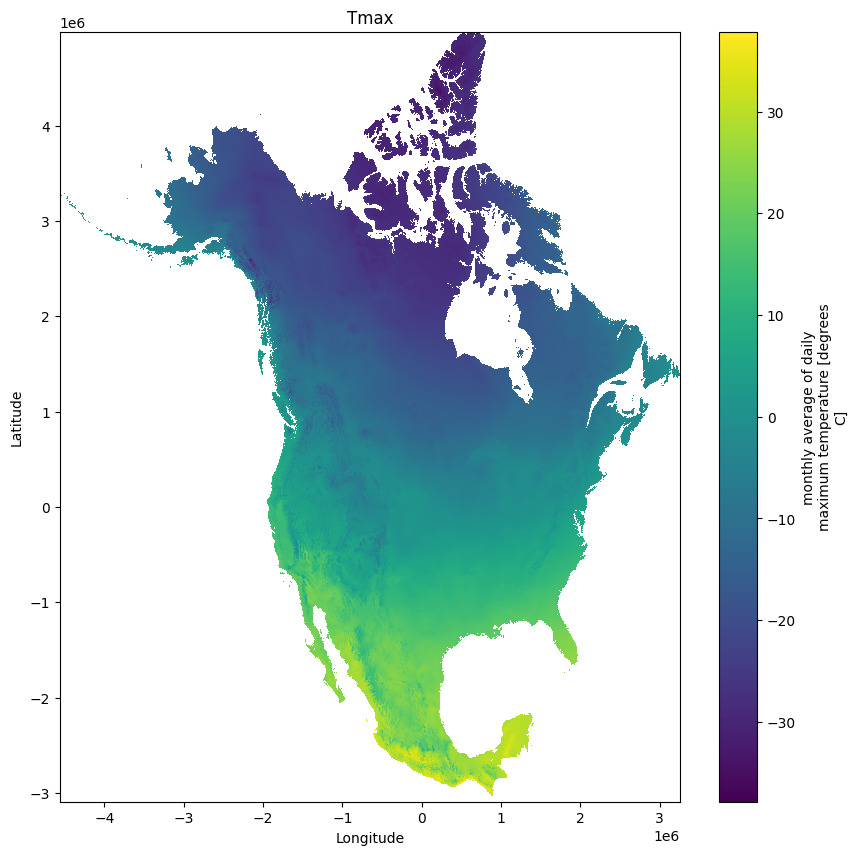

In [ ]:
# Check if any datasets are loaded
if len(datasets) > 0:
    # Select the first dataset
    ds = datasets[0]

    # Print dataset information to help identify spatial dimensions and variables
    print(ds)

    # Set the spatial dimensions of the dataset
    ds = ds.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)

    # Set the coordinate reference system (CRS) of the dataset
    ds = ds.rio.write_crs("epsg:4326", inplace=True)

    # Identify the variable to plot based on user's selection
    var_to_plot = selected_option.split('/')[-1].split('_')[0]

    # Check if the variable exists in the dataset
    if var_to_plot in ds:
        # Plot the data
        fig, ax = plt.subplots(figsize=(10, 10))
        ds[var_to_plot].isel(time=0).plot(ax=ax, cmap='viridis', add_colorbar=True)
        plt.title(var_to_plot.capitalize())
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()
    else:
        print(f"The variable '{var_to_plot}' is not found in the dataset.")
else:
    print("No datasets are loaded.")


###Example of cropping Daymet data to a county

In [ ]:
# Define the Daymet CRS using the Proj4 string
daymet_crs = pyproj.CRS.from_proj4("+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")
# Based on this: https://daymet.ornl.gov/overview

# Transform the counties shapefile to the Daymet CRS
counties_shapefile = counties_shapefile.to_crs(daymet_crs)

# Check if any datasets are loaded
if len(datasets) > 0:
    # Select the first dataset
    ds = datasets[0]

    # Extract the year from the dataset's attributes
    year = ds.attrs.get('start_year', 'unknown_year')

    # Set the spatial dimensions of the dataset
    ds = ds.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)

    # Set the coordinate reference system (CRS) of the dataset
    ds = ds.rio.write_crs(daymet_crs.to_string(), inplace=True)

    # Identify the variable to plot based on user's selection
    var_to_plot = selected_option.split('/')[-1].split('_')[0]

    # Check if the variable exists in the dataset
    if var_to_plot in ds:
        # Initialize a DataFrame to store the results
        results_df = pd.DataFrame(columns=['State', 'County', 'Year', var_to_plot])

        # Initialize a counter for the number of counties processed
        county_count = 0

        # Iterate over each county in the counties shapefile
        for idx, row in counties_shapefile.iterrows():
            # Clip the data to the current county's boundaries
            try:
                clipped = ds[var_to_plot].rio.clip([row['geometry']], ds.rio.crs, drop=True, invert=False)

                # Calculate the average value within the county
                avg_value = clipped.mean().values.item()

                # Append the results to the DataFrame
                results_df = results_df.append({'State': row['NAME_1'], 'County': row['NAME_2'], 'Year': year, var_to_plot: avg_value}, ignore_index=True)

                # Plot the data
                fig, ax = plt.subplots(figsize=(10, 10))
                clipped.isel(time=0).plot(ax=ax, cmap='viridis', add_colorbar=True)
                plt.title(f"{var_to_plot.capitalize()} in {row['NAME_2']}, {row['NAME_1']} ({year})")
                plt.xlabel('X (meters)')
                plt.ylabel('Y (meters)')
                plt.show()

                # Increment the county counter
                county_count += 1

                # Break the loop if 3 counties have been processed
                if county_count >= 3:
                    break

            except rioxarray.exceptions.NoDataInBounds:
                print(f"No data found in bounds for {row['NAME_2']}, {row['NAME_1']}.")
                continue

        # Display the results DataFrame
        print(results_df)

    else:
        print(f"The variable '{var_to_plot}' is not found in the dataset.")
else:
    print("No datasets are loaded.")


NameError: ignored

###This will take a very long time. It will clip downloaded netCDF data to shapefile and put average values into a CSV table. Only run this after downloading all desired netCDF files

In [ ]:
import os
import pandas as pd
import xarray as xr
import rioxarray
import pyproj
import datetime
from shapely.geometry import mapping

# Define the Daymet CRS
daymet_crs = pyproj.CRS.from_proj4("+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")

# Transform the counties shapefile to the Daymet CRS
counties_shapefile = counties_shapefile.to_crs(daymet_crs)

# Get the current working directory
current_dir = os.getcwd()

# Directory containing NetCDF files
netcdf_dir = os.path.join(current_dir, '/content/drive/MyDrive/Mantises!/output/netcdf_files')

# Initialize DataFrame for results
results_df = pd.DataFrame(columns=['State', 'County', 'Year', 'Month'])

# Set the maximum number of counties and datasets to process
max_counties = 1  # or len(counties_shapefile) to process all
max_datasets = 3  # or len(dataset_files) to process all

# Total number of files and counties
total_files = len([file for file in os.listdir(netcdf_dir) if file.endswith('.nc')])
total_counties = len(counties_shapefile)

# Process each NetCDF file
processed_files = 0
for file in os.listdir(netcdf_dir):
    if file.endswith('.nc'):
        processed_files += 1
        if processed_files > max_datasets:
            break
        print(f"Processing file {processed_files}/{total_files}: {file}")

        dataset_path = os.path.join(netcdf_dir, file)
        dataset = xr.open_dataset(dataset_path)
        year = dataset.attrs.get('start_year', 'unknown_year')

        # Extract the variable name (3rd term in the filename)
        var_name = file.split('_')[2]

        # Check if the variable exists in the dataset
        if var_name not in dataset:
            print(f"Variable '{var_name}' not found in file: {file}")
            continue

        # Set CRS for the dataset
        dataset = dataset.rio.write_crs(daymet_crs.to_string())

        # Process each month
        for time_index in range(len(dataset.time)):
            month_data = dataset[var_name].isel(time=time_index)
            month = month_data.time.dt.month.item()

            # Process each county
            processed_counties = 0
            for _, row in counties_shapefile.iterrows():
                processed_counties += 1
                if processed_counties > max_counties:
                    break
                print(f"Processing county {processed_counties}/{total_counties} for month {month} of year {year}")

                clipped = month_data.rio.clip([mapping(row['geometry'])], crs=daymet_crs.to_string(), drop=True)
                avg_value = clipped.mean().values.item()

                # Append results
                new_row = pd.DataFrame([{
                    'State': row['NAME_1'],
                    'County': row['NAME_2'],
                    'Year': year,
                    'Month': month,
                    var_name: avg_value
                }])
                if not new_row.isna().all().all():
                    results_df = pd.concat([results_df, new_row], ignore_index=True)

        dataset.close()

# Generate timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Save results to CSV with timestamp
csv_path = os.path.join(current_dir, f'/content/drive/MyDrive/Mantises!/ouput/climatic_data/climatic_data_{timestamp}.csv')
results_df.to_csv(csv_path, index=False)

print("All files processed.")


OSError: ignored